In [1]:
import time
import math
from functools import partial
from tqdm.auto import tqdm
from tqdm.utils import _term_move_up

prefix = _term_move_up() + '\r'

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# from mamba import Mamba, MambaConfig
from mamba_ssm import Mamba
# from mamba_ssm.modules.mamba_simple import Block
from mamba_ssm.models.mixer_seq_simple import create_block, _init_weights

from transformers import get_cosine_schedule_with_warmup

from data import DrawingDataset

%load_ext autoreload
%autoreload 2

2024-03-06 17:24:34.404671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 17:24:35.033900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(0))

True
NVIDIA GeForce GTX 1080
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8110MB, multi_processor_count=20)


In [3]:
batch_size = 512
max_length = 100

train_dataset = DrawingDataset(data_path="./data", split="train", max_length=max_length)
val_dataset = DrawingDataset(data_path="./data", split="valid", max_length=max_length)
test_dataset = DrawingDataset(data_path="./data", split="test", max_length=max_length)

train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 1/345 [00:00<00:04, 79.90it/s]


In [4]:
# class mambaBlock(nn.Module):
#     def __init__(self, d_model, d_state, d_conv, expand, n_layers):
#         super(mambaBlock, self).__init__()
#         self.d_model = d_model
#         self.d_state = d_state
#         self.d_conv = d_conv
#         self.expand = expand
#         self.n_layers = n_layers
#         self.layers = []

#         self.layers = nn.ModuleList([Mamba(d_model, d_state, d_conv, expand) for _ in range(n_layers)])

#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x

class customModel(nn.Module):
    def __init__(self, nb, no, ns, embed_dim):
        super(customModel, self).__init__()
        
        self.embed_dim = embed_dim
        self.proj = nn.Linear(in_features=5, out_features=self.embed_dim, bias=False)
        
        self.m1 = nn.ModuleList([create_block(self.embed_dim , device='cuda', layer_idx=f'm{i}') for i in range(nb)])
        self.leftm = nn.ModuleList([create_block(self.embed_dim , device='cuda', layer_idx=f'l{i}') for i in range(no)])
        self.rightm = nn.ModuleList([create_block(self.embed_dim , device='cuda', layer_idx=f'r{i}') for i in range(ns)])
        
        self.offset_hidden = nn.Linear(in_features=self.embed_dim, out_features=16)
        self.relu = nn.ReLU()
        self.offset_out = nn.Linear(in_features=16, out_features=2)
        self.state_out = nn.Linear(in_features=self.embed_dim, out_features=3, bias=False)
        
        initializer_cfg = None
        for layer in self.m1:
            layer.apply(partial(_init_weights, n_layer=nb, **(initializer_cfg if initializer_cfg is not None else {})))
        for layer in self.leftm:
            layer.apply(partial(_init_weights, n_layer=no, **(initializer_cfg if initializer_cfg is not None else {})))
        for layer in self.rightm:
            layer.apply(partial(_init_weights, n_layer=ns, **(initializer_cfg if initializer_cfg is not None else {})))
        
            

    def forward(self, x): # x is of shape (B, L, 5) (Batchsize, sequence length, dimension)
        x = self.proj(x)
        hidden_states, residuals = x, None
        for layer in self.m1:
            hidden_states, residuals = layer(hidden_states, residuals)
        
        left_hidden_states, left_residuals = hidden_states, residuals
        right_hidden_states, right_residuals = hidden_states, residuals

        for layer in self.leftm:
            left_hidden_states, left_residuals = layer(left_hidden_states, left_residuals)
        for layer in self.rightm:
            right_hidden_states, right_residuals = layer(right_hidden_states, right_residuals)
        
        offset_out = self.relu(self.offset_hidden(left_hidden_states))
        offset_out = self.offset_out(offset_out)
        state_out = self.state_out(right_hidden_states)
        return offset_out, state_out

    @torch.inference_mode()
    def generate(model, input_seq):
        prev = input_seq
        
        i = 0
        while i < 20:
            offset, state = model.forward(prev)
            indices = torch.argmax(state, dim=-1)
            one_hot = torch.nn.functional.one_hot(indices, 3)
            pred = torch.cat((offset, one_hot), dim=-1)
            next_seg = pred[:, -1:, :]
            prev = torch.cat((prev, next_seg), dim=1)
            i += 1
        
        return prev

    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))

In [5]:
log_interval = 10
epochs = 50

batches = len(train)

model = customModel(nb=3, no=20, ns=2, embed_dim=32).to("cuda")

offset_crit = nn.MSELoss(reduction='none')
state_crit = nn.CrossEntropyLoss()

#optimizer = torch.optim.RAdam(model.parameters(), lr=5e-4)
warmup_ratio = 0.03

print(0.05 * math.sqrt(batch_size / (batches * epochs)))
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, betas=(0.99, 0.95), eps=1e-4,
                              weight_decay=0.05 * math.sqrt(batch_size / (batches * epochs)))   
# scheduler = get_cosine_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=batches * warmup_ratio,
#                                             num_training_steps=batches)

writer = SummaryWriter('./logs')

def train_model(model, data_loader, optimizer, epoch):
    model.train()
    
    size = len(data_loader)
    
    # Total Losses
    total_loss = 0
    total_offset_loss = 0
    total_state_loss = 0
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    running_correct = 0
    running_total = 0
    
    running_mse = 0
    
    start_time = time.time()
    
    for i, data in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        
        inputs, targets = data
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")
        
        offsets, states = model(inputs)
        
        # Split Target
        offset_target = targets[:, :, :2]
        state_target = targets[:, :, 2:].argmax(dim=-1)
        no_pad_mask = state_target != 2
        
        # Masked MSE Loss for offset
        offset_loss = offset_crit(offsets, offset_target)
        offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
        
        offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
        
        # Cross Entropy Loss for State
        state_loss = state_crit(states.transpose(1, 2), state_target)
        loss = offset_loss + state_loss
        
        # Calculate other metrics (accuracy)
        with torch.no_grad():
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = state_target.flatten() != 2

            running_correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            running_total += states_pred.flatten()[no_pad_mask].size().numel()
            
            flat_offsets_pred = offsets.reshape(-1, 2)[no_pad_mask, :]
            flat_offset_target = targets[:, :, :2].reshape(-1, 2)[no_pad_mask, :]
            running_mse += nn.functional.mse_loss(flat_offsets_pred, flat_offset_target)
        
        # Backprop
        loss.backward(retain_graph=True)
        
        # Gradient Clipping
        for name, param in model.named_parameters():
            torch.nn.utils.clip_grad_norm_(param, max_norm=1.5)
        
        # Optimizer Steps
        optimizer.step()
        
        running_loss += loss.item()
        running_offset_loss += offset_loss.item()
        running_state_loss += state_loss.item()
        
        total_loss += loss.item()
        total_offset_loss += offset_loss.item()
        total_state_loss += state_loss.item()
        
        # Print speed, losses, and accuracy every 25 batchs
        if i % log_interval == 0 and i > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = running_loss / log_interval
            cur_offset_loss = running_offset_loss / log_interval
            cur_state_loss = running_state_loss / log_interval
            cur_accuracy = running_correct / running_total
            cur_mse = running_mse / log_interval
            tqdm.write(f'{prefix}| epoch {(epoch+1):3d} | {i:5d}/{size:5d} batches '
                  f'| ms/batch {ms_per_batch:5.2f} | '
                  f'offset_loss {cur_offset_loss:5.2f} | state_loss {cur_state_loss:5.4f} | '
                  f'accuracy {cur_accuracy:5.4f} | mse {cur_mse:5.2f}')
            time.sleep(0)
            running_loss = 0
            running_offset_loss = 0
            running_state_loss = 0
            running_correct = 0
            running_total = 0
            running_mse = 0
            start_time = time.time()
    
    return total_loss / size, total_offset_loss / size, total_state_loss / size
        
def evaluate_model(model, data_loader):
    model.eval()
    size = len(data_loader)
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    # Correct
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            inputs = inputs.to("cuda")
            targets = targets.to("cuda")
            
            offsets, states = model(inputs)
            
            # Masked MSE Loss
            offset_target = targets[:, :, :2]
            state_target = targets[:, :, 2:].argmax(dim=-1)
            no_pad_mask = state_target != 2
            
            offset_loss = offset_crit(offsets, offset_target)
            offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
            offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
            
            state_loss = state_crit(states.transpose(1, 2), state_target)
            loss = offset_loss + state_loss
            
            # Accuracy Calculation
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = no_pad_mask.flatten()
            
            correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            total_samples += states_pred.flatten()[no_pad_mask].size().numel()
            
            running_loss += loss.item()
            running_offset_loss += offset_loss.item()
            running_state_loss += state_loss.item()
    
    return running_loss / size, running_offset_loss / size, running_state_loss / size, correct / total_samples
            


0.013669722523468176


In [6]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train_loss, train_offset_loss, train_state_loss = train_model(model, train, optimizer, epoch)
    print(f"Training: Epoch: {epoch+1}, offset_loss: {train_offset_loss:5.4f}, state_loss: {train_state_loss:5.4f}")
    writer.add_scalar("Train/Loss/Epoch", train_loss, epoch)
    writer.add_scalar("Train/Offset_Loss/Epoch", train_offset_loss, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", train_state_loss, epoch)
    
    val_loss, val_offset_loss, val_state_loss, val_accuracy = evaluate_model(model, val)
    print(f"Validation: Epoch: {epoch+1}, offset_loss: {val_offset_loss:5.2f}, state_loss: {val_state_loss:5.4f}, accuracy: {val_accuracy:5.4f}")
    writer.add_scalar("Train/Loss/Epoch", val_loss, epoch)
    writer.add_scalar("Train/Offset_Loss/Epoch", val_offset_loss, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", val_state_loss, epoch)
    
    #scheduler.step()

  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   1 |   130/  137 batches | ms/batch 499.56 | offset_loss 11283.80 | state_loss 0.2350 | accuracy 0.8547 | mse 5641.90
Training: Epoch: 1, offset_loss: 11370.8118, state_loss: 0.4015


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 1, offset_loss: 10507.05, state_loss: 0.2139, accuracy: 0.8604


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   2 |   130/  137 batches | ms/batch 497.80 | offset_loss 10231.31 | state_loss 0.1845 | accuracy 0.8596 | mse 5115.66
Training: Epoch: 2, offset_loss: 10161.6975, state_loss: 0.1961


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 2, offset_loss: 10004.32, state_loss: 0.1797, accuracy: 0.8627


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   3 |   130/  137 batches | ms/batch 504.17 | offset_loss 9250.67 | state_loss 0.1743 | accuracy 0.8664 | mse 4625.345
Training: Epoch: 3, offset_loss: 9655.3123, state_loss: 0.1786


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 3, offset_loss: 9539.04, state_loss: 0.1722, accuracy: 0.8643


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   4 |   130/  137 batches | ms/batch 513.68 | offset_loss 8662.59 | state_loss 0.1739 | accuracy 0.8653 | mse 4331.309
Training: Epoch: 4, offset_loss: 9081.0848, state_loss: 0.1734


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 4, offset_loss: 8649.42, state_loss: 0.1724, accuracy: 0.8642


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   5 |   130/  137 batches | ms/batch 499.26 | offset_loss 6965.34 | state_loss 0.1810 | accuracy 0.8590 | mse 3482.67
Training: Epoch: 5, offset_loss: 7697.4250, state_loss: 0.1780


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 5, offset_loss: 6809.74, state_loss: 0.1854, accuracy: 0.8602


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   6 |   130/  137 batches | ms/batch 496.10 | offset_loss 5869.24 | state_loss 0.1722 | accuracy 0.8507 | mse 2934.62
Training: Epoch: 6, offset_loss: 6209.1253, state_loss: 0.1768


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 6, offset_loss: 5851.76, state_loss: 0.1651, accuracy: 0.8540


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   7 |   130/  137 batches | ms/batch 498.95 | offset_loss 5122.60 | state_loss 0.1541 | accuracy 0.8580 | mse 2561.30
Training: Epoch: 7, offset_loss: 5371.6465, state_loss: 0.1584


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 7, offset_loss: 5031.70, state_loss: 0.1524, accuracy: 0.8588


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   8 |   130/  137 batches | ms/batch 509.55 | offset_loss 4609.09 | state_loss 0.1469 | accuracy 0.8587 | mse 2304.54
Training: Epoch: 8, offset_loss: 4736.5116, state_loss: 0.1500


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 8, offset_loss: 4636.53, state_loss: 0.1447, accuracy: 0.8586


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch   9 |   130/  137 batches | ms/batch 498.91 | offset_loss 4436.92 | state_loss 0.1426 | accuracy 0.8629 | mse 2218.46
Training: Epoch: 9, offset_loss: 4481.2142, state_loss: 0.1441


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 9, offset_loss: 4462.05, state_loss: 0.1406, accuracy: 0.8626


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  10 |   130/  137 batches | ms/batch 495.24 | offset_loss 4288.66 | state_loss 0.1400 | accuracy 0.8622 | mse 2144.33
Training: Epoch: 10, offset_loss: 4337.1805, state_loss: 0.1413


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 10, offset_loss: 4346.76, state_loss: 0.1385, accuracy: 0.8651


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  11 |   130/  137 batches | ms/batch 497.43 | offset_loss 4240.09 | state_loss 0.1379 | accuracy 0.8669 | mse 2120.04
Training: Epoch: 11, offset_loss: 4253.6820, state_loss: 0.1396


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 11, offset_loss: 4263.37, state_loss: 0.1372, accuracy: 0.8660


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  12 |   130/  137 batches | ms/batch 502.43 | offset_loss 4139.44 | state_loss 0.1370 | accuracy 0.8649 | mse 2069.72
Training: Epoch: 12, offset_loss: 4196.4860, state_loss: 0.1387


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 12, offset_loss: 4235.24, state_loss: 0.1365, accuracy: 0.8669


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  13 |   130/  137 batches | ms/batch 499.50 | offset_loss 4067.80 | state_loss 0.1381 | accuracy 0.8654 | mse 2033.90
Training: Epoch: 13, offset_loss: 4145.6335, state_loss: 0.1377


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 13, offset_loss: 4176.66, state_loss: 0.1356, accuracy: 0.8666


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  14 |   130/  137 batches | ms/batch 486.61 | offset_loss 4135.70 | state_loss 0.1371 | accuracy 0.8659 | mse 2067.85
Training: Epoch: 14, offset_loss: 4107.3539, state_loss: 0.1369


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 14, offset_loss: 4130.52, state_loss: 0.1349, accuracy: 0.8685


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  15 |   130/  137 batches | ms/batch 485.01 | offset_loss 4117.67 | state_loss 0.1368 | accuracy 0.8652 | mse 2058.83
Training: Epoch: 15, offset_loss: 4075.3128, state_loss: 0.1363


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 15, offset_loss: 4140.51, state_loss: 0.1349, accuracy: 0.8664


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  16 |   130/  137 batches | ms/batch 486.25 | offset_loss 4076.10 | state_loss 0.1354 | accuracy 0.8640 | mse 2038.05
Training: Epoch: 16, offset_loss: 4053.1468, state_loss: 0.1359


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 16, offset_loss: 4088.51, state_loss: 0.1341, accuracy: 0.8662


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  17 |   130/  137 batches | ms/batch 490.23 | offset_loss 4036.18 | state_loss 0.1358 | accuracy 0.8640 | mse 2018.09
Training: Epoch: 17, offset_loss: 4040.4518, state_loss: 0.1356


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 17, offset_loss: 4102.45, state_loss: 0.1339, accuracy: 0.8652


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  18 |   130/  137 batches | ms/batch 488.73 | offset_loss 4053.68 | state_loss 0.1361 | accuracy 0.8653 | mse 2026.84
Training: Epoch: 18, offset_loss: 4023.0281, state_loss: 0.1352


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 18, offset_loss: 4072.35, state_loss: 0.1334, accuracy: 0.8666


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  19 |   130/  137 batches | ms/batch 486.17 | offset_loss 4002.35 | state_loss 0.1357 | accuracy 0.8635 | mse 2001.17
Training: Epoch: 19, offset_loss: 4008.2333, state_loss: 0.1349


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 19, offset_loss: 4067.43, state_loss: 0.1339, accuracy: 0.8663


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  20 |   130/  137 batches | ms/batch 486.50 | offset_loss 4035.86 | state_loss 0.1349 | accuracy 0.8638 | mse 2017.93
Training: Epoch: 20, offset_loss: 3983.3646, state_loss: 0.1347


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 20, offset_loss: 4047.01, state_loss: 0.1330, accuracy: 0.8655


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  21 |   130/  137 batches | ms/batch 487.88 | offset_loss 3898.34 | state_loss 0.1344 | accuracy 0.8638 | mse 1949.17
Training: Epoch: 21, offset_loss: 3962.7533, state_loss: 0.1345


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 21, offset_loss: 4035.74, state_loss: 0.1331, accuracy: 0.8672


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  22 |   130/  137 batches | ms/batch 486.63 | offset_loss 3911.59 | state_loss 0.1330 | accuracy 0.8649 | mse 1955.80
Training: Epoch: 22, offset_loss: 3944.3074, state_loss: 0.1340


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 22, offset_loss: 3993.29, state_loss: 0.1320, accuracy: 0.8663


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  23 |   130/  137 batches | ms/batch 488.14 | offset_loss 3942.14 | state_loss 0.1349 | accuracy 0.8644 | mse 1971.07
Training: Epoch: 23, offset_loss: 3937.3317, state_loss: 0.1336


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 23, offset_loss: 3999.85, state_loss: 0.1320, accuracy: 0.8681


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  24 |   130/  137 batches | ms/batch 484.69 | offset_loss 3975.22 | state_loss 0.1340 | accuracy 0.8655 | mse 1987.61
Training: Epoch: 24, offset_loss: 3917.6211, state_loss: 0.1335


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 24, offset_loss: 3996.53, state_loss: 0.1321, accuracy: 0.8677


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  25 |   130/  137 batches | ms/batch 489.24 | offset_loss 3927.32 | state_loss 0.1334 | accuracy 0.8658 | mse 1963.66
Training: Epoch: 25, offset_loss: 3909.5034, state_loss: 0.1332


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 25, offset_loss: 3979.26, state_loss: 0.1313, accuracy: 0.8652


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  26 |   130/  137 batches | ms/batch 492.75 | offset_loss 3934.78 | state_loss 0.1339 | accuracy 0.8646 | mse 1967.39
Training: Epoch: 26, offset_loss: 3910.9219, state_loss: 0.1329


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 26, offset_loss: 3977.97, state_loss: 0.1311, accuracy: 0.8666


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  27 |   130/  137 batches | ms/batch 491.56 | offset_loss 3868.03 | state_loss 0.1334 | accuracy 0.8649 | mse 1934.01
Training: Epoch: 27, offset_loss: 3894.2842, state_loss: 0.1327


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 27, offset_loss: 3982.53, state_loss: 0.1313, accuracy: 0.8689


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  28 |   130/  137 batches | ms/batch 488.23 | offset_loss 3919.31 | state_loss 0.1340 | accuracy 0.8651 | mse 1959.66
Training: Epoch: 28, offset_loss: 3879.8588, state_loss: 0.1324


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 28, offset_loss: 3961.91, state_loss: 0.1306, accuracy: 0.8674


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  29 |   130/  137 batches | ms/batch 486.07 | offset_loss 3806.22 | state_loss 0.1317 | accuracy 0.8675 | mse 1903.11
Training: Epoch: 29, offset_loss: 3876.1836, state_loss: 0.1322


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 29, offset_loss: 3980.49, state_loss: 0.1304, accuracy: 0.8668


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  30 |   130/  137 batches | ms/batch 486.61 | offset_loss 3863.98 | state_loss 0.1316 | accuracy 0.8665 | mse 1931.99
Training: Epoch: 30, offset_loss: 3866.9966, state_loss: 0.1319


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 30, offset_loss: 3968.97, state_loss: 0.1301, accuracy: 0.8666


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  31 |   130/  137 batches | ms/batch 490.97 | offset_loss 3850.18 | state_loss 0.1319 | accuracy 0.8645 | mse 1925.09
Training: Epoch: 31, offset_loss: 3847.0826, state_loss: 0.1316


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 31, offset_loss: 3946.63, state_loss: 0.1298, accuracy: 0.8656


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  32 |   130/  137 batches | ms/batch 487.01 | offset_loss 3851.11 | state_loss 0.1311 | accuracy 0.8651 | mse 1925.55
Training: Epoch: 32, offset_loss: 3846.8435, state_loss: 0.1313


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 32, offset_loss: 3964.87, state_loss: 0.1295, accuracy: 0.8680


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  33 |   130/  137 batches | ms/batch 489.06 | offset_loss 3864.58 | state_loss 0.1307 | accuracy 0.8661 | mse 1932.29
Training: Epoch: 33, offset_loss: 3839.7114, state_loss: 0.1312


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 33, offset_loss: 3943.22, state_loss: 0.1294, accuracy: 0.8671


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  34 |   130/  137 batches | ms/batch 487.25 | offset_loss 3855.92 | state_loss 0.1313 | accuracy 0.8674 | mse 1927.96
Training: Epoch: 34, offset_loss: 3830.2631, state_loss: 0.1310


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 34, offset_loss: 3958.14, state_loss: 0.1292, accuracy: 0.8678


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  35 |   130/  137 batches | ms/batch 487.33 | offset_loss 3818.46 | state_loss 0.1313 | accuracy 0.8667 | mse 1909.23
Training: Epoch: 35, offset_loss: 3817.5087, state_loss: 0.1307


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 35, offset_loss: 3943.61, state_loss: 0.1290, accuracy: 0.8655


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  36 |   130/  137 batches | ms/batch 485.94 | offset_loss 3824.00 | state_loss 0.1305 | accuracy 0.8698 | mse 1912.00
Training: Epoch: 36, offset_loss: 3818.8082, state_loss: 0.1307


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 36, offset_loss: 3965.19, state_loss: 0.1288, accuracy: 0.8677


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  37 |   130/  137 batches | ms/batch 483.30 | offset_loss 3821.14 | state_loss 0.1301 | accuracy 0.8662 | mse 1910.57
Training: Epoch: 37, offset_loss: 3804.2598, state_loss: 0.1305


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 37, offset_loss: 3937.97, state_loss: 0.1290, accuracy: 0.8683


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  38 |   130/  137 batches | ms/batch 486.66 | offset_loss 3841.71 | state_loss 0.1307 | accuracy 0.8656 | mse 1920.85
Training: Epoch: 38, offset_loss: 3789.8846, state_loss: 0.1303


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 38, offset_loss: 3927.94, state_loss: 0.1285, accuracy: 0.8655


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  39 |   130/  137 batches | ms/batch 487.50 | offset_loss 3848.53 | state_loss 0.1311 | accuracy 0.8636 | mse 1924.26
Training: Epoch: 39, offset_loss: 3783.2660, state_loss: 0.1301


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 39, offset_loss: 3937.65, state_loss: 0.1288, accuracy: 0.8703


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  40 |   130/  137 batches | ms/batch 486.76 | offset_loss 3801.24 | state_loss 0.1303 | accuracy 0.8667 | mse 1900.62
Training: Epoch: 40, offset_loss: 3784.5429, state_loss: 0.1302


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 40, offset_loss: 3964.37, state_loss: 0.1284, accuracy: 0.8671


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  41 |   130/  137 batches | ms/batch 486.48 | offset_loss 3853.43 | state_loss 0.1294 | accuracy 0.8666 | mse 1926.71
Training: Epoch: 41, offset_loss: 3769.5411, state_loss: 0.1299


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 41, offset_loss: 3921.54, state_loss: 0.1280, accuracy: 0.8685


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  42 |   130/  137 batches | ms/batch 487.31 | offset_loss 3756.72 | state_loss 0.1295 | accuracy 0.8667 | mse 1878.36
Training: Epoch: 42, offset_loss: 3766.5983, state_loss: 0.1298


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 42, offset_loss: 3911.29, state_loss: 0.1278, accuracy: 0.8673


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  43 |   130/  137 batches | ms/batch 487.85 | offset_loss 3877.92 | state_loss 0.1297 | accuracy 0.8671 | mse 1938.96
Training: Epoch: 43, offset_loss: 3760.4707, state_loss: 0.1295


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 43, offset_loss: 3940.51, state_loss: 0.1276, accuracy: 0.8676


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  44 |   130/  137 batches | ms/batch 488.91 | offset_loss 3765.52 | state_loss 0.1304 | accuracy 0.8637 | mse 1882.76
Training: Epoch: 44, offset_loss: 3749.3346, state_loss: 0.1292


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 44, offset_loss: 3925.87, state_loss: 0.1274, accuracy: 0.8671


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  45 |   130/  137 batches | ms/batch 487.95 | offset_loss 3758.16 | state_loss 0.1293 | accuracy 0.8656 | mse 1879.08
Training: Epoch: 45, offset_loss: 3739.8323, state_loss: 0.1290


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 45, offset_loss: 3930.56, state_loss: 0.1273, accuracy: 0.8690


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  46 |   130/  137 batches | ms/batch 489.47 | offset_loss 3759.02 | state_loss 0.1282 | accuracy 0.8685 | mse 1879.51
Training: Epoch: 46, offset_loss: 3729.6402, state_loss: 0.1289


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 46, offset_loss: 3924.29, state_loss: 0.1269, accuracy: 0.8686


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  47 |   130/  137 batches | ms/batch 487.95 | offset_loss 3727.26 | state_loss 0.1283 | accuracy 0.8681 | mse 1863.63
Training: Epoch: 47, offset_loss: 3738.4207, state_loss: 0.1288


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 47, offset_loss: 3923.96, state_loss: 0.1269, accuracy: 0.8669


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  48 |   130/  137 batches | ms/batch 486.21 | offset_loss 3723.40 | state_loss 0.1291 | accuracy 0.8662 | mse 1861.70
Training: Epoch: 48, offset_loss: 3718.7228, state_loss: 0.1286


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 48, offset_loss: 3930.88, state_loss: 0.1268, accuracy: 0.8693


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  49 |   130/  137 batches | ms/batch 485.96 | offset_loss 3741.91 | state_loss 0.1286 | accuracy 0.8673 | mse 1870.96
Training: Epoch: 49, offset_loss: 3708.5414, state_loss: 0.1283


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 49, offset_loss: 3933.84, state_loss: 0.1264, accuracy: 0.8689


  0%|          | 0/137 [00:00<?, ?it/s]

| epoch  50 |   130/  137 batches | ms/batch 488.24 | offset_loss 3750.32 | state_loss 0.1275 | accuracy 0.8686 | mse 1875.16
Training: Epoch: 50, offset_loss: 3709.2294, state_loss: 0.1282


  0%|          | 0/5 [00:00<?, ?it/s]

Validation: Epoch: 50, offset_loss: 3934.78, state_loss: 0.1266, accuracy: 0.8670


In [7]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test: offset_loss: 3849.90, state_loss: 0.1273, accuracy: 0.8695


In [8]:
model.save('./saved/model.pth')

In [11]:
loaded_model = customModel(nb=3, no=20, ns=2, embed_dim=32).to("cuda")
loaded_model.load('./saved/model.pth')

In [12]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(loaded_model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test: offset_loss: 3848.62, state_loss: 0.1274, accuracy: 0.8695


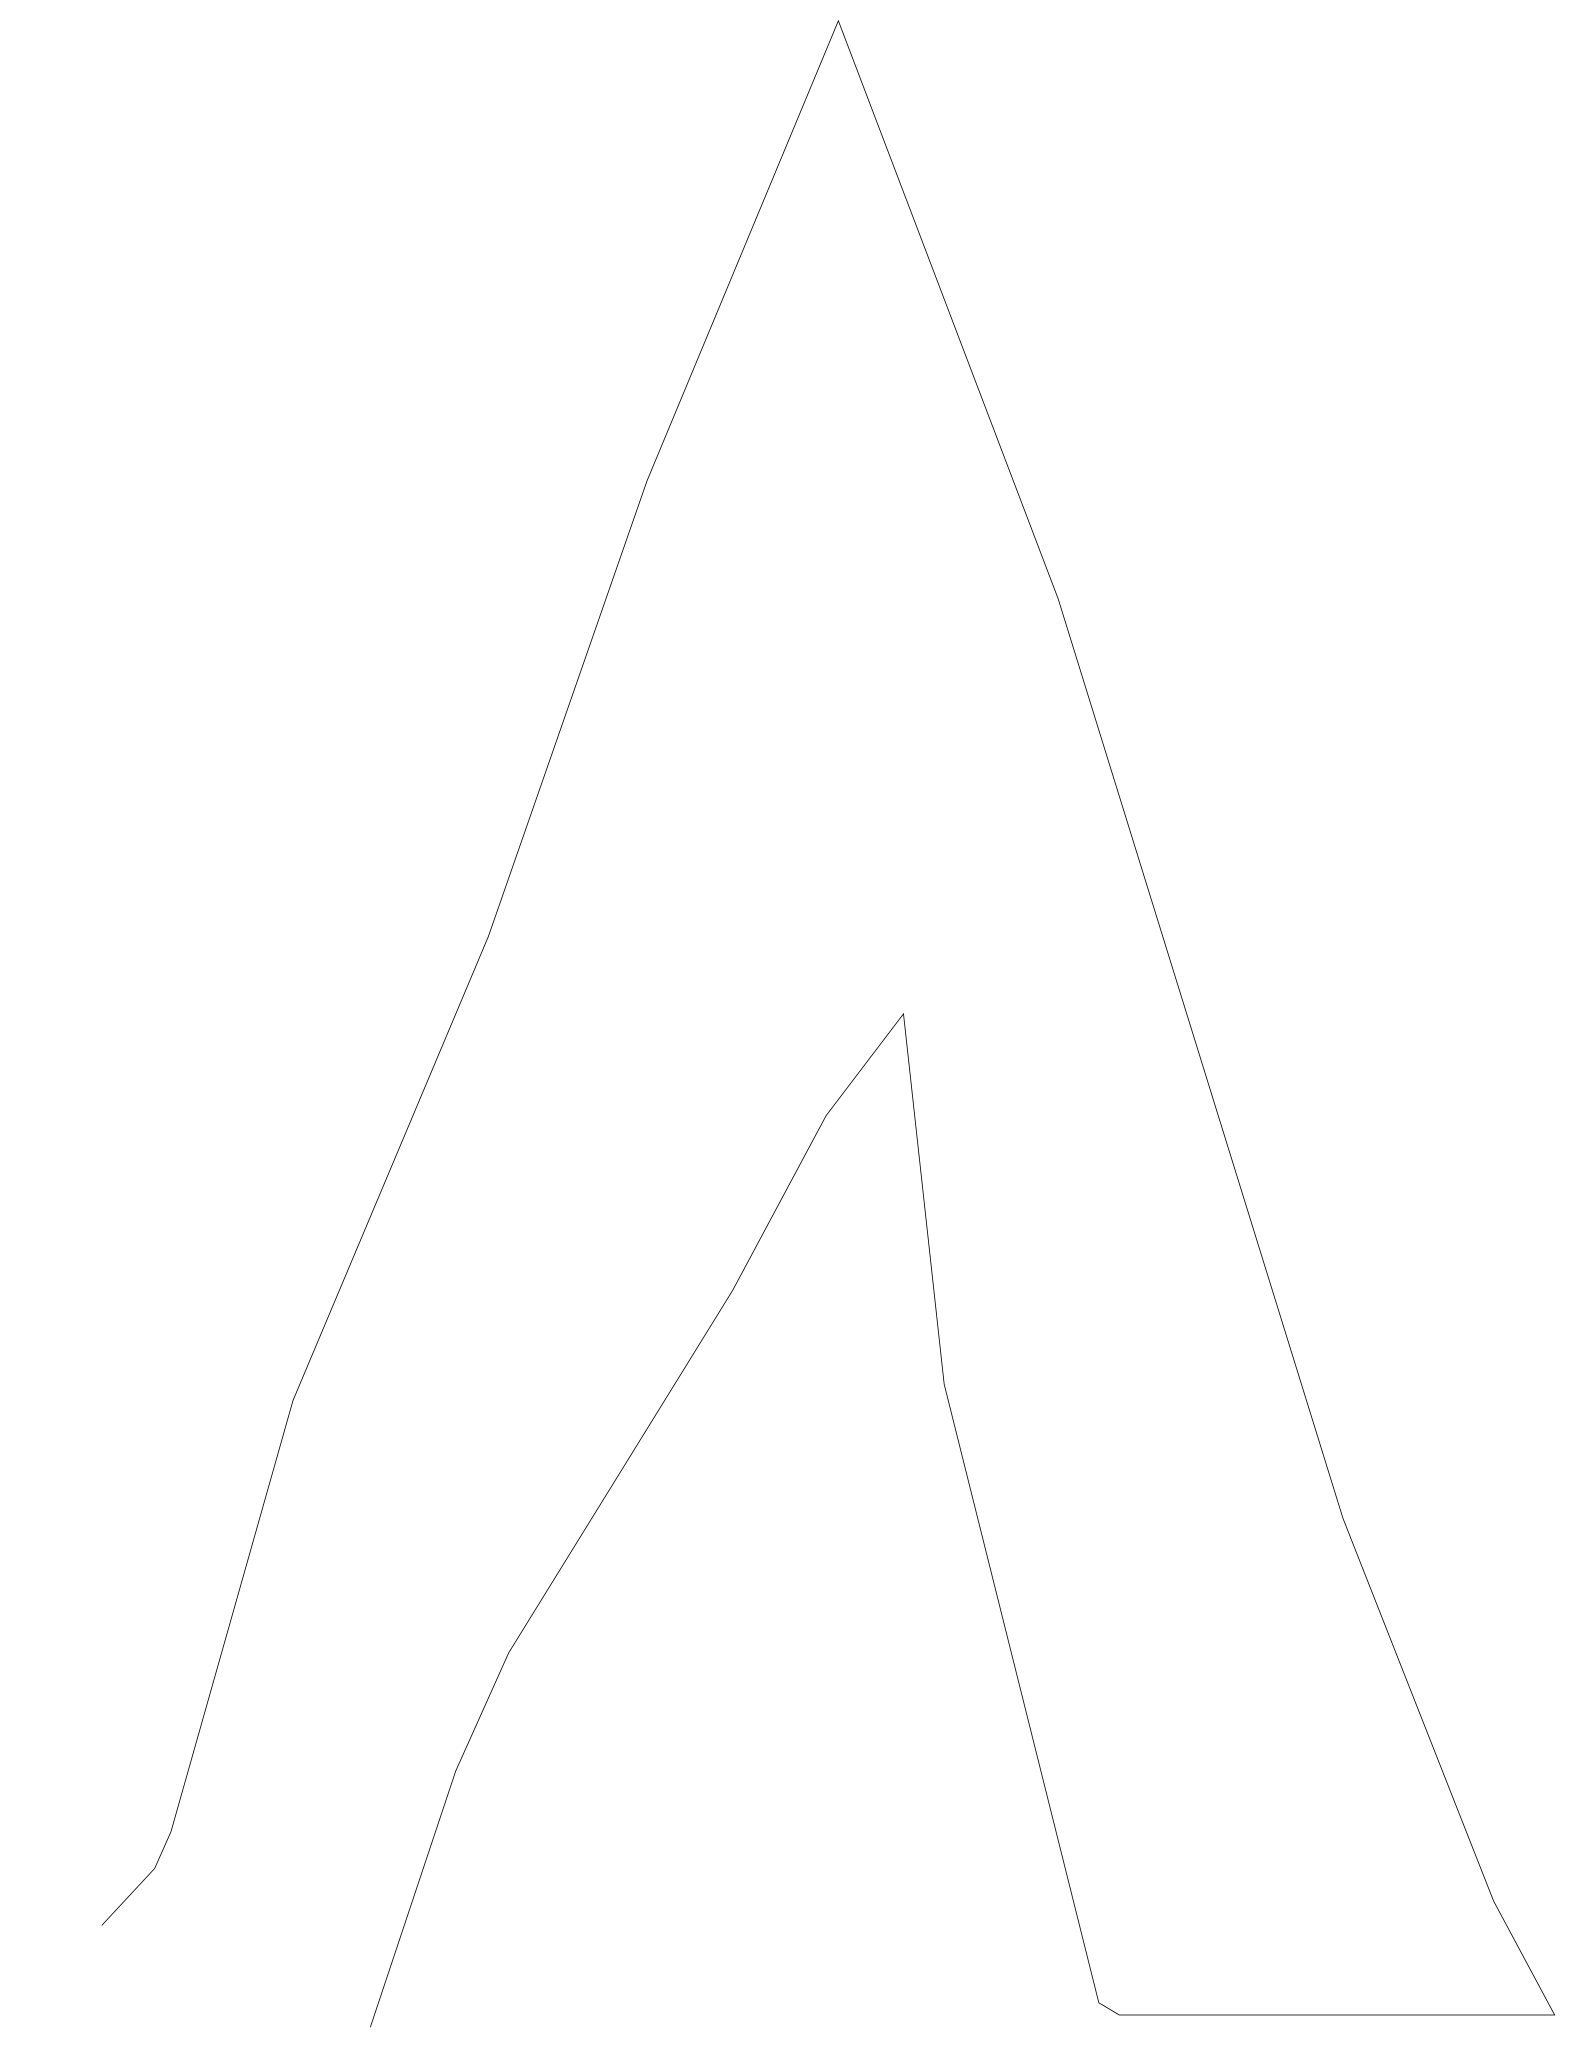

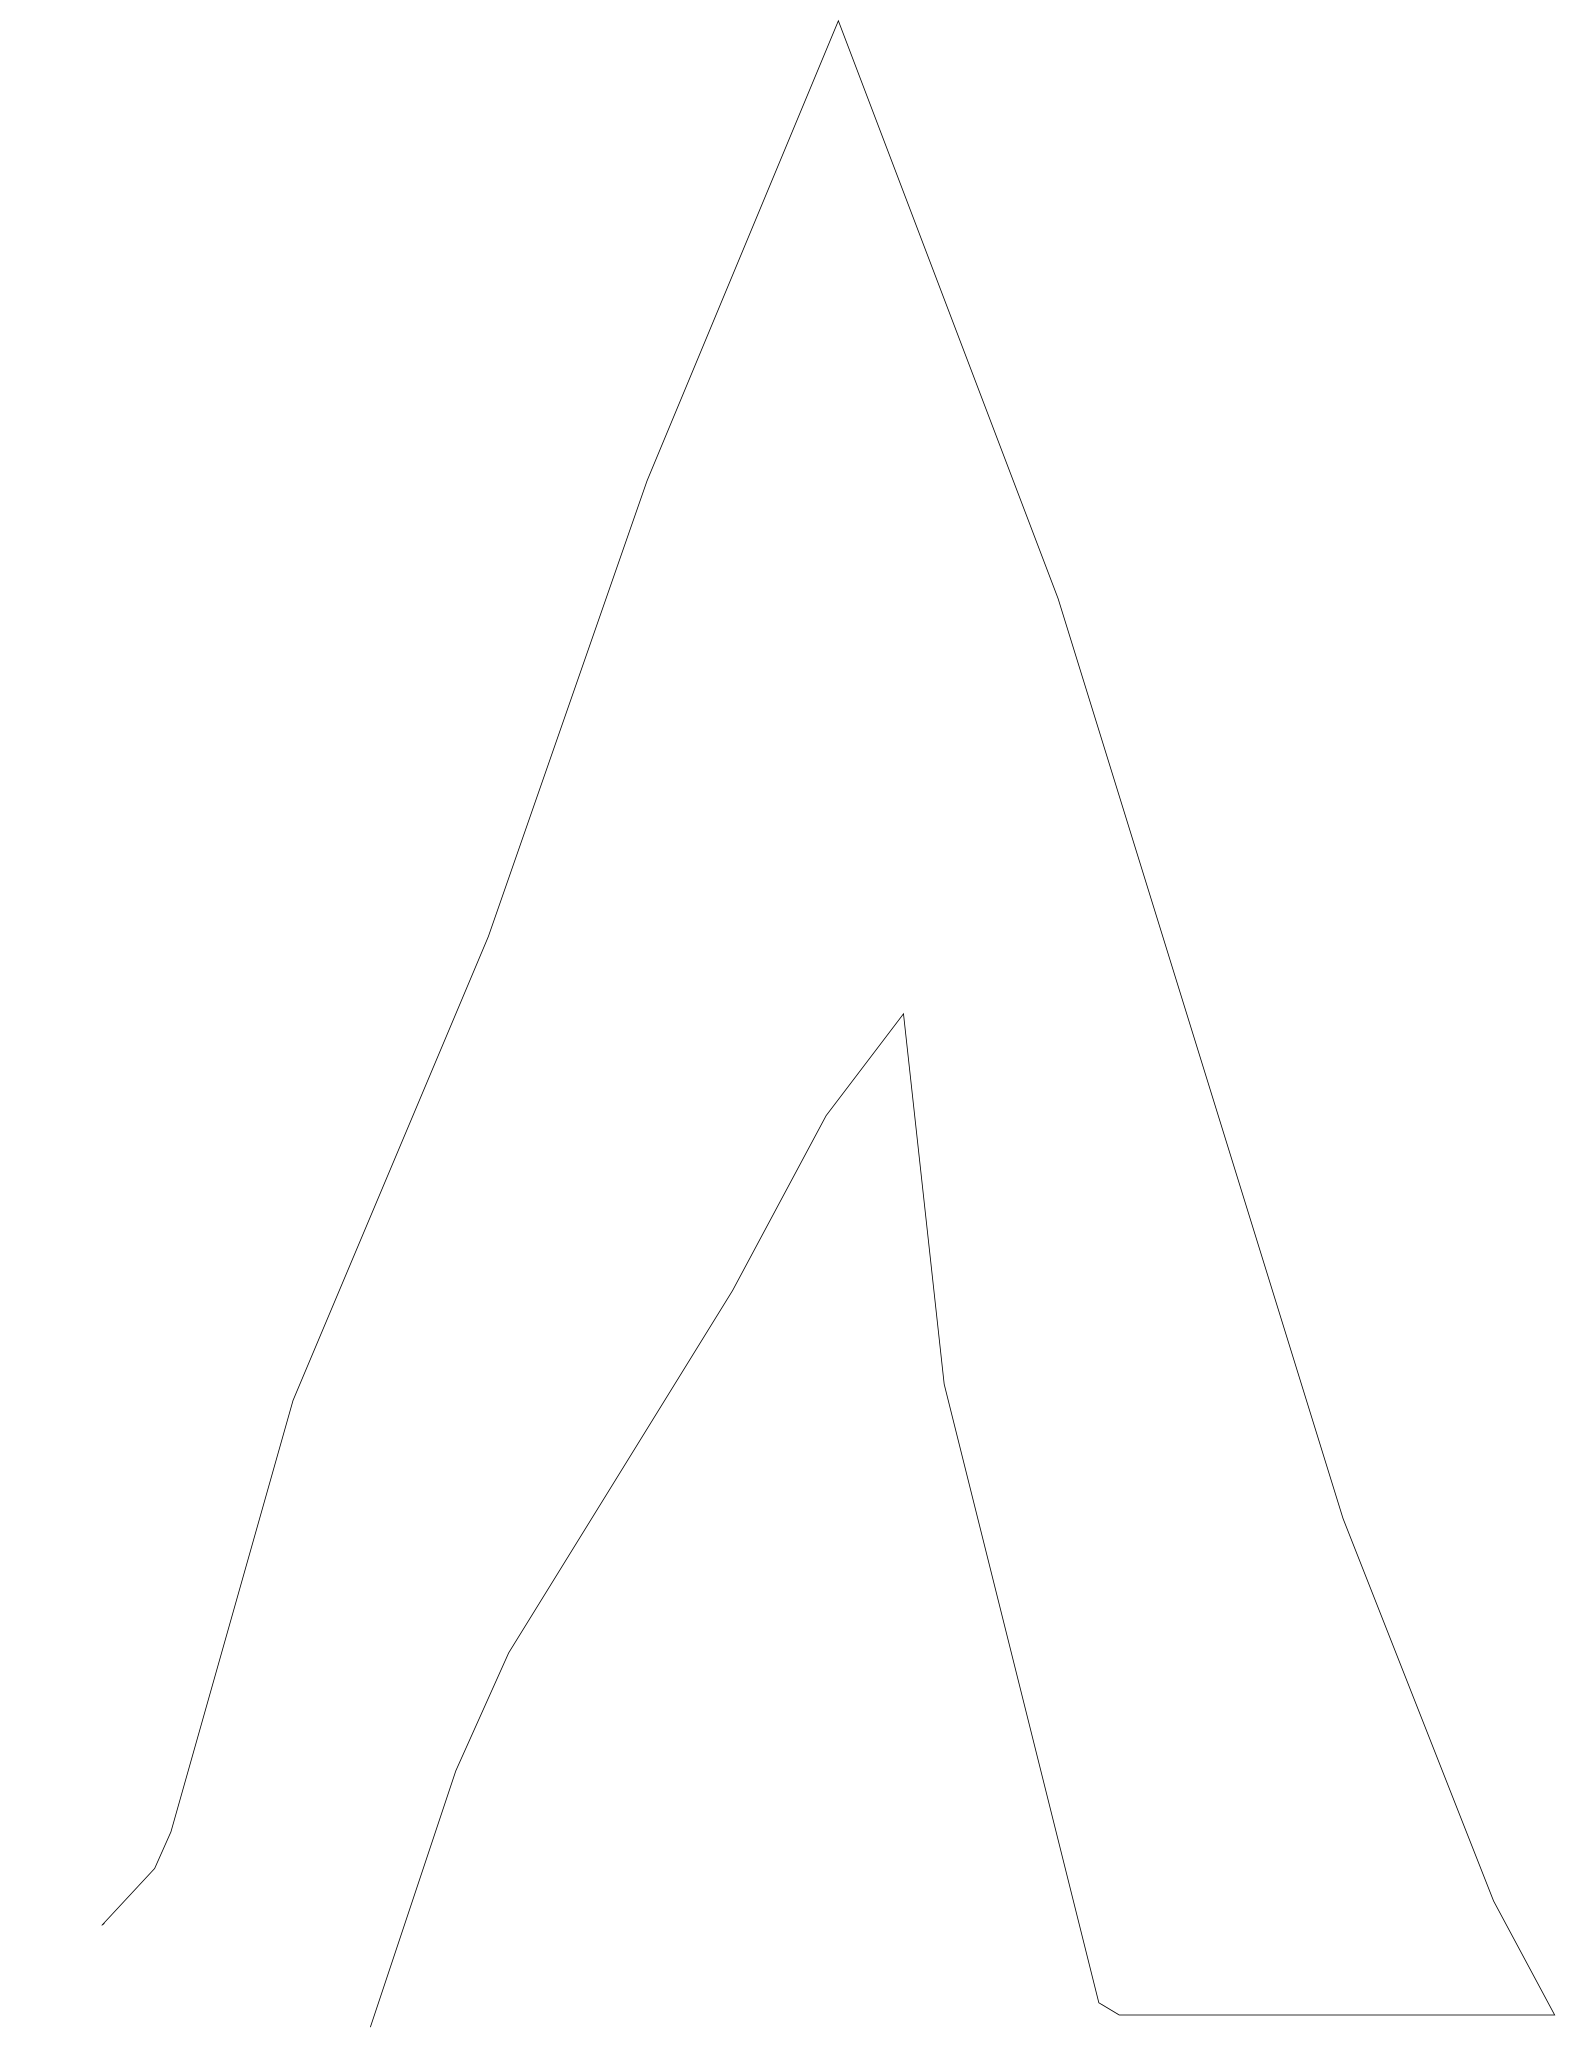

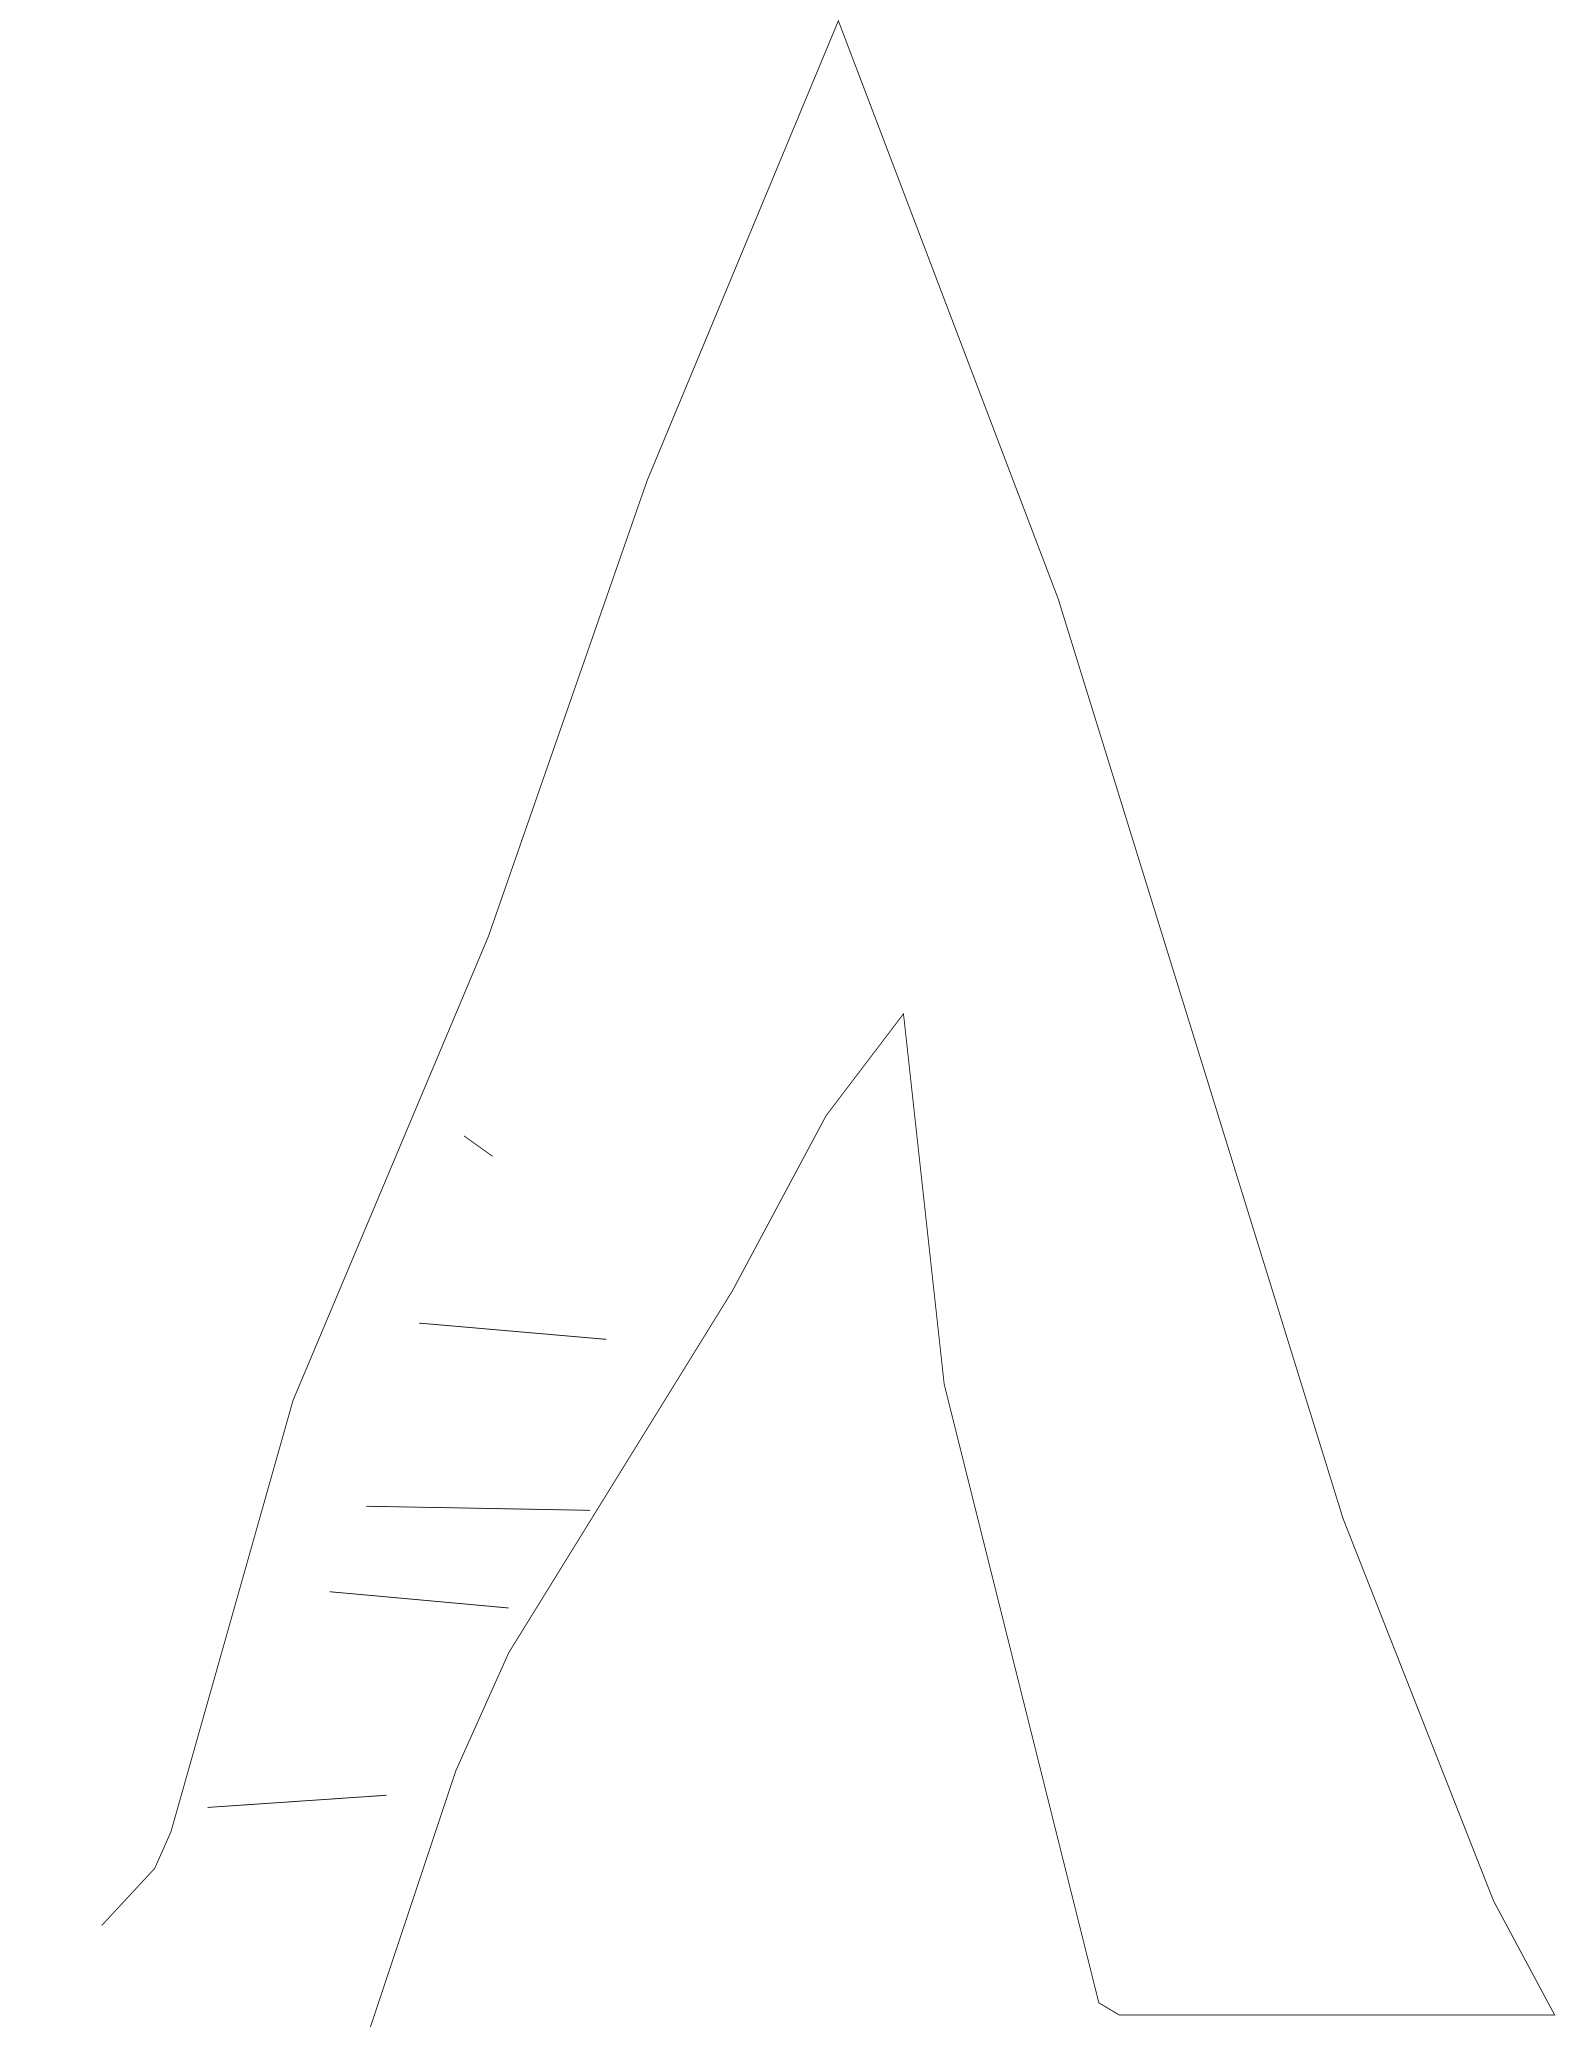

In [13]:
from utils import draw_strokes

@torch.inference_mode()
def generate(model, input_seq):
    prev = input_seq
    
    i = 0
    while i < 20:
        offset, state = model.forward(prev)
        indices = torch.argmax(state, dim=-1)
        one_hot = torch.nn.functional.one_hot(indices, 3)
        pred = torch.cat((offset, one_hot), dim=-1)
        next_seg = pred[:, -1:, :]
        prev = torch.cat((prev, next_seg), dim=1)
        i += 1
    
    return prev

strokes = train_dataset[10][0]
i = (strokes[:20]).unsqueeze(0)

output_pred = generate(model, i.to("cuda")).cpu().numpy()[0]
output_actual = strokes[:30].numpy()
draw_strokes(i[0], svg_filename='./input.svg')
draw_strokes(output_pred, svg_filename='./sample.svg')
draw_strokes(output_actual, svg_filename='./actual.svg')